
##### Import Needed Libraries

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt 
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

##### Data Importation and Inspection

In [4]:
# Import Data
taiwan_df = pd.read_csv("Taiwan_Data.csv")
taiwan_df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [5]:
taiwan_df.shape

(6819, 96)

In [6]:
taiwan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [7]:
# Check for missing values
num_null = taiwan_df.isna().sum()
for col in taiwan_df.columns:
    if num_null[col] >= 1:
        print(f"{col}: {num_null[col]} missing values")


In [8]:
# Check for duplicates
taiwan_df.duplicated().sum()

0

In [9]:
# Convert the target Variable
taiwan_df["Bankrupt?"]= np.where(taiwan_df["Bankrupt?"] ==1, True, False)
taiwan_df["Bankrupt?"].dtype

dtype('bool')

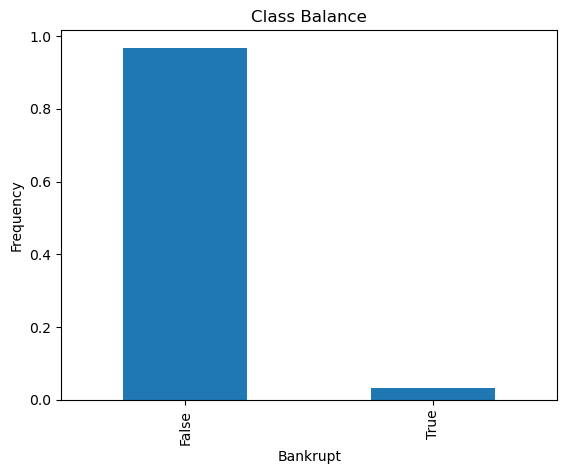

In [10]:
# Check for class balance 
fig, ax = plt.subplots()
taiwan_df["Bankrupt?"].value_counts(normalize=True).plot(kind="bar")
ax.set_xlabel("Bankrupt")
ax.set_ylabel("Frequency")
ax.set_title("Class Balance");

In [11]:
taiwan_df.describe()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,0.012679,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,0.781567,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,0.781635,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,0.781735,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


#### Model Building and Evaluation

In [13]:
# Variable split 
target = "Bankrupt?"
X= taiwan_df.drop(columns=target)
y=taiwan_df[target]
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (6819, 95)
y shape: (6819,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5455, 95)
y_train shape: (5455,)
X_test shape: (1364, 95)
y_test shape: (1364,)


In [15]:
#Resample
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(f"X_train_over shape: {X_train_over.shape}")

X_train_over shape: (10572, 95)


In [16]:
# 
clf = {
    "Gradient Boosting":GradientBoostingClassifier(random_state = 42),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state = 42),
    "Random Forest": RandomForestClassifier(random_state = 42)
}
for name, model in clf.items():
    print(f"{name}: {model}")


Gradient Boosting: GradientBoostingClassifier(random_state=42)
DecisionTreeClassifier: DecisionTreeClassifier(random_state=42)
Random Forest: RandomForestClassifier(random_state=42)


In [17]:
for name, model in clf.items():
    cv_scores  = cross_val_score(model, X_train_over, y_train_over, cv=5, n_jobs=-1)
    print(cv_scores)

[0.9678487  0.97446809 0.97114475 0.97114475 0.97019868]
[0.98865248 0.98723404 0.98628193 0.98817408 0.98817408]
[0.99338061 0.99432624 0.99432356 0.99668874 0.99432356]


In [18]:
params = {
    "max_depth": range(30, 50, 10),
    "n_estimators": range(25, 51, 25),
}

model = GridSearchCV(clf["Random Forest"], param_grid=params, cv=5, n_jobs=-1, verbose=1)
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(30, 50, 10),
                         'n_estimators': range(25, 51, 25)},
             verbose=1)

In [19]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.031625,0.060629,0.025879,0.004404,30,25,"{'max_depth': 30, 'n_estimators': 25}",0.992435,0.992908,0.991958,0.991485,0.991485,0.992054,0.000553,4
1,3.886676,0.087918,0.033495,0.002601,30,50,"{'max_depth': 30, 'n_estimators': 50}",0.992435,0.992908,0.993377,0.994324,0.992431,0.993095,0.000707,3
2,1.972415,0.030829,0.025392,0.006082,40,25,"{'max_depth': 40, 'n_estimators': 25}",0.992908,0.994326,0.993851,0.993851,0.994797,0.993946,0.000627,2
3,3.176109,0.257638,0.019726,0.004068,40,50,"{'max_depth': 40, 'n_estimators': 50}",0.992435,0.995745,0.994797,0.996216,0.995743,0.994987,0.001357,1


In [20]:
best_params = model.best_params_
print(best_params)

{'max_depth': 40, 'n_estimators': 50}


In [21]:
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)

print("Model Training Accuracy:", round(acc_train, 4))
print("Model Test Accuracy:", round(acc_test, 4))

Model Training Accuracy: 1.0
Model Test Accuracy: 0.9663


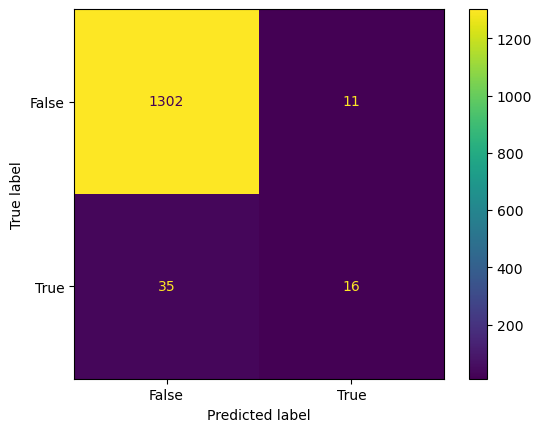

In [22]:
# Plot confusion matrix
fig, ax =plt.subplots()
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax);

In [23]:
class_report = classification_report(y_test, model.predict(X_test))  
print(class_report)

              precision    recall  f1-score   support

       False       0.97      0.99      0.98      1313
        True       0.59      0.31      0.41        51

    accuracy                           0.97      1364
   macro avg       0.78      0.65      0.70      1364
weighted avg       0.96      0.97      0.96      1364



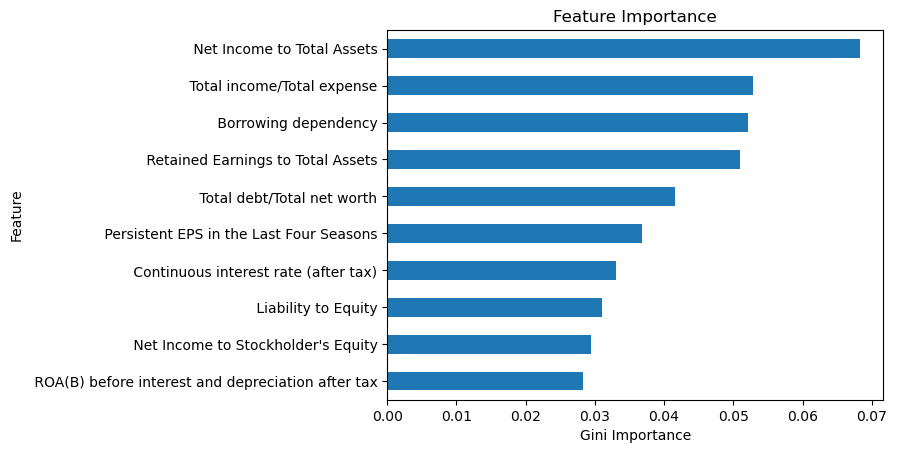

In [24]:
 # Get feature names from training data
fig, ax = plt.subplots()
features = X_train_over.columns

# Extract importances from model and create a series with feature names and importances
importances = model.best_estimator_.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values()

# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
ax.set_xlabel("Gini Importance")
ax.set_ylabel("Feature")
plt.title("Feature Importance");

In [25]:
# Save model
with open("random_classifier_Model.pkl", "wb") as f:
    pickle.dump(model, f)